In [1]:
!pip install transformers

In [2]:
!pip install torch

In [27]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

def embeddings_inference(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=24, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)

    return mean_pooling(model_output, encoded_input['attention_mask'])[0]


In [293]:
import pandas as pd
import json

with open('items.json', 'rb') as file:
    data = json.load(file)

In [294]:
data = data['result']

In [295]:
content_df = pd.DataFrame(data)

In [22]:
from bs4 import BeautifulSoup

df['description'] = df['description'].map(lambda x: BeautifulSoup(x).text)

In [30]:
embeddings = []
for i, description in enumerate(df['description']):
    embeddings.append(embeddings_inference(description))

    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [31]:
s = pd.Series(embeddings)

In [33]:
df['embeddings'] = s

In [296]:
content_df['id'] = content_df['id'].map(lambda x: content_item_to_id[x])

In [263]:
from annoy import AnnoyIndex

index = AnnoyIndex(1024, 'angular')

item_to_id = dict()

for i, item in enumerate(df.to_dict(orient='records')):
    item_to_id.update({item['id']: i})
    # index.add_item(i, item['embeddings'])


In [52]:
index.get_nns_by_item(0, 10)

[0, 4685, 4795, 4898, 5881, 5278, 5637, 11196, 5323, 5132]

In [265]:
content_item_to_id = item_to_id

In [59]:
index.save('./models/generate/content/index.ann')

True

In [61]:
import pickle
with open('./models/generate/content/index_to_id.pickle', 'wb') as file:
    pickle.dump(item_to_id, file)

In [62]:
with open('./models/generate/content/dataset.pickle', 'wb') as file:
    pickle.dump(df, file)

In [63]:
!pip install implicit

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 1.2 MB/s eta 0:00:0000:0100:01
  Using cached scipy-1.12.0-cp311-cp311-macosx_12_0_arm64.whl (31.4 MB)


In [266]:
from scipy.sparse import csr_matrix

user_to_id = dict()

with open('users.json', 'rb') as file:
    users = json.load(file)['result']

    for i, user in enumerate(users):
        user_to_id.update({user['id']: i})


In [267]:
with open('relations.json', 'rb') as file:
    df = pd.DataFrame(json.load(file)['result'])

In [268]:
df = df[df.status == 'FINISHED']

In [269]:
df = df.sort_values('date_create')

In [270]:
import datetime

df['date_create'] = pd.to_datetime(df['date_create'])

In [271]:
list(df['date_create'])[-1] - df['date_create'][0]

Timedelta('485 days 18:30:41.542000')

<Axes: xlabel='date_create,date_create,date_create'>

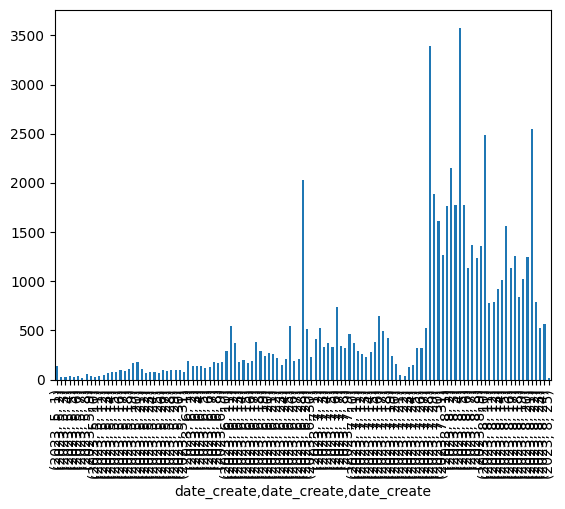

In [145]:
df[df.date_create.dt.date>=datetime.date(2023, 5, 1)]['date_create'].groupby([df["date_create"].dt.year, df["date_create"].dt.month, df['date_create'].dt.day]).count().plot(kind='bar')

In [285]:
ids = set(list(df['client_id']))
user_to_id = dict()

for i, user in enumerate(ids):
    user_to_id.update({user: i})

df['client_id'] = df['client_id'].map(lambda x: user_to_id[x])

In [273]:
df = df[df.external_Id.isin(content_item_to_id.keys())]

df['external_Id'] = df['external_Id'].map(lambda x: content_item_to_id[x])

In [274]:
df

,id,external_Id,supplier_id,tariff_id,client_id,status,tickets_count,date_create,activeSince,activeUntil,product_type_code
10972,32702,961,-1,6516,2600,FINISHED,1,2020-07-02 10:26:08.008000+00:00,,,EVENT
10971,32703,961,-1,6612,2600,FINISHED,3,2020-07-02 10:35:26.375000+00:00,,,EVENT
10969,32607,181,-1,6606,2600,FINISHED,2,2020-07-02 11:08:31.087000+00:00,,,EVENT
10943,32620,181,-1,6605,801,FINISHED,2,2020-07-02 15:50:29.719000+00:00,,,
10942,32621,181,-1,6604,2600,FINISHED,8,2020-07-02 16:10:06.308000+00:00,,,
...,...,...,...,...,...,...,...,...,...,...,...
104514,42946457,17460,44153,52954,26108623,FINISHED,1,2023-08-25 03:34:45.965000+00:00,2023-08-31T16:30:00+03:00,2023-08-31T18:00:00+03:00,PROMO_EXCURSION
104513,42946458,620,32815,55100,26108624,FINISHED,1,2023-08-25 03:57:08.433000+00:00,2023-08-25T10:00:00+03:00,2023-08-25T10:00:00+03:00,
104510,42946461,66,10110,55006,26108627,FINISHED,4,2023-08-25 04:15:09.607000+00:00,2023-08-27T07:30:00+03:00,2023-08-27T20:00:00+03:00,
104509,42946462,66,10110,55006,26108628,FINISHED,2,2023-08-25 04:15:57.181000+00:00,2023-08-25T07:30:00+03:00,2023-08-25T20:00:00+03:00,


In [286]:
import numpy as np
from scipy.sparse import coo_matrix

client_ids = np.array(list(df['client_id'].map(int)), dtype=int)
items_ids = np.array(list(df['external_Id'].map(int)), dtype=int)
weights = np.array([1 for _ in range(len(items_ids))])

print(client_ids.dtype, items_ids.dtype, weights.dtype)

matrix = coo_matrix((weights, (client_ids, items_ids)))

int64 int64 int64


In [287]:
matrix

<30974x21636 sparse matrix of type '<class 'numpy.int64'>'
	with 37133 stored elements in COOrdinate format>

In [288]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=50)

model.fit(matrix)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0005908012390136719 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [301]:
df[df.client_id==1], content_df[content_df.id==20950]

(              id  external_Id  supplier_id  tariff_id  client_id    status  \
 100817  42942392        20950        44153      54884          1  FINISHED   
 
         tickets_count                      date_create  \
 100817              5 2023-08-21 09:08:45.154000+00:00   
 
                       activeSince                activeUntil product_type_code  
 100817  2023-08-31T19:00:00+03:00  2023-08-31T20:30:00+03:00   PROMO_EXCURSION  ,
           id                                     titlte  \
 20950  20950  Цирковой дивертисмент «Улочки московские»   
 
                                              description     screen  \
 20950  <p>«Улочки московские» — цирковой дивертисмент...  excursion   
 
       coordinates  
 20950         NaN  )

In [304]:
csr = matrix.tocsr()
content_df[content_df.id.isin(model.recommend(2150, csr[2150])[0])]

[1370 2223 3487    0  885 2131  261   70 4172 2385]


,id,titlte,description,screen,coordinates
0,0,Ресторан «The Сад»,<p>Ресторан «The Сад» славится своей субтропич...,restaurant,NaN
70,70,Ресторан AQ Kitchen,<p>Авторский проект испанского шеф-повара Адри...,restaurant,NaN
261,261,Центр «Космонавтика и авиация» на ВДНХ,"<p>Павильон, в котором любил бывать Юрий Гагар...",event,"{'lng': 37.62194444047548, 'lat': 55.835006175..."
885,885,Музей кино,<p>В Музее кино хранятся костюмы и реквизит из...,event,"{'lng': 37.6167905, 'lat': 55.83964349999999}"
1370,1370,Смотровая площадка «Выше только любовь»,"<p>Находится на высоте 354 метров, обгоняя Ост...",event,"{'lng': 37.5343747, 'lat': 55.7499443}"
2131,2131,Кафе «Спецбуфет особого назначения»,<p>Кафе располагается в «Гараже особого назнач...,restaurant,NaN
2223,2223,Флорариум,<p>Оранжерейный комплекс парка — это особый «к...,event,"{'lng': 37.62969155557252, 'lat': 55.751731257..."
2385,2385,Ресторан KUZNYAHOUSE,<p>Ресторан в здании бывшей кузницы на Новой Г...,restaurant,NaN
3487,3487,Музей «Дом Бурганова»,<p>Музей посвящен творчеству Александра Бурган...,event,"{'lng': 37.59719, 'lat': 55.746507}"
4172,4172,Музей русской гармоники А. Мирека,<p>Перед вами оживет история конструкторской м...,event,"{'lng': 37.59456379999999, 'lat': 55.7719669}"


In [297]:
content_df[content_df.id==20048]

,id,titlte,description,screen,coordinates
20048,20048,Мастер-класс по созданию скетчбука,<p>Декор для альбома художника Вначале два опр...,excursion,NaN


In [305]:
import pickle

with open('./models/generate/relations/model.pickle', 'wb') as file:
    pickle.dump(model, file)

In [306]:
with open('./models/generate/relations/dataset.pickle', 'wb') as file:
    pickle.dump(df, file)

In [307]:
with open('./models/generate/relations/item_to_id.pickle', 'wb') as file:
    pickle.dump(item_to_id, file)

In [308]:
with open('./models/generate/relations/user_to_id.pickle', 'wb') as file:
    pickle.dump(user_to_id, file)

In [ ]:
with open('./models/generate/relations/csr.pickle', 'wb') as file:
    pickle.dump(csr, file)